In [ ]:
# Instalar dependencias necesarias
!pip install tensorflow scikit-learn opencv-python matplotlib


  Using cached tensorflow-2.18.0-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.0-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.68.1-cp39-cp39-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached h5py-3.12.1-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using cached ml_dtyp

In [3]:
!pip install roboflow

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import pandas as pd

In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="GwLFNxXqCXUUeiaWbvyg")
project = rf.workspace("proyectos-lyiyx").project("ecuador-traffic-detection")
version = project.version(6)
dataset = version.download("yolov8")

# Rutas del dataset descargado
dataset_path = dataset.location  # Ruta base del dataset descargado
train_images_dir = os.path.join(dataset_path, "train", "images")
train_labels_dir = os.path.join(dataset_path, "train", "labels")
valid_images_dir = os.path.join(dataset_path, "valid", "images")
valid_labels_dir = os.path.join(dataset_path, "valid", "labels")
test_images_dir = os.path.join(dataset_path, "test", "images")
test_labels_dir = os.path.join(dataset_path, "test", "labels")

loading Roboflow workspace...
loading Roboflow project...


In [8]:
# Dimensiones de las imágenes
IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_CLASSES = 2

# Función para cargar datos desde las carpetas
def load_data(images_dir, labels_dir):
    images = []
    labels = []
    for filename in os.listdir(images_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(images_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)

            label_path = os.path.join(labels_dir, filename.replace(".jpg", ".txt").replace(".png", ".txt"))
            with open(label_path, "r") as f:
                line = f.readline().strip()
                class_id = int(line.split()[0])
                labels.append(class_id)
    images = np.array(images, dtype="float32") / 255.0
    labels = np.array(labels)
    return images, labels

# Cargar datos
X_train, y_train = load_data(train_images_dir, train_labels_dir)
X_valid, y_valid = load_data(valid_images_dir, valid_labels_dir)
X_test, y_test = load_data(test_images_dir, test_labels_dir)

# Convertir etiquetas a formato categórico
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# Crear 10 folds para validación cruzada
X_train, y_train = shuffle(X_train, y_train, random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = list(skf.split(X_train, np.argmax(y_train, axis=1)))

In [10]:
# Función para crear modelos con transfer learning
def create_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_efficientnetb0():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = [create_resnet50, create_vgg16, create_efficientnetb0]


Entrenando modelo 1...

Fold 1
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 166s 2us/step
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4958 - loss: 0.9695 - val_accuracy: 0.4409 - val_loss: 0.7343
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5177 - loss: 0.7680 - val_accuracy: 0.5591 - val_loss: 0.6795
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5543 - loss: 0.6909 - val_accuracy: 0.5591 - val_loss: 0.6740
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5613 - loss: 0.6860 - val_accuracy: 0.5699 - val_loss: 0.6711
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5890 - loss: 0.6753 - val_accuracy: 0.6129 - val_loss: 0.6659
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5737 - loss: 0.6814 - val_accuracy: 0.5806 - val_loss: 0.6637
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5860 - loss: 0.6698 - val_accuracy: 0.6129 - val_loss: 0.6632
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━

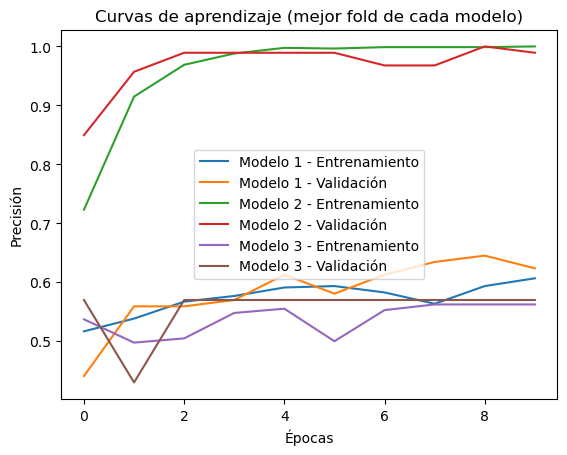

In [12]:
# Inicializar almacenamiento de métricas
metrics_summary = []
roc_data = []

for model_id, model_fn in enumerate(models):
    print(f"Entrenando modelo {model_id + 1}...")
    fold_accuracies = []
    fold_losses = []
    best_fold_history = None
    best_accuracy = 0

    for fold, (train_idx, val_idx) in enumerate(folds):
        print(f"\nFold {fold + 1}")
        model = model_fn()
        history = model.fit(
            X_train[train_idx], y_train[train_idx],
            validation_data=(X_train[val_idx], y_train[val_idx]),
            epochs=10,
            batch_size=32,
            verbose=1
        )
        _, accuracy = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)
        loss = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)[0]
        fold_accuracies.append(accuracy)
        fold_losses.append(loss)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_history = history

    mean_accuracy = np.mean(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    metrics_summary.append({
        "Modelo": ["ResNet50", "VGG16", "EfficientNetB0"][model_id],
        "Precisión promedio": mean_accuracy,
        "Pérdida promedio": mean_loss
    })

    if best_fold_history:
        plt.plot(best_fold_history.history['accuracy'], label=f'Modelo {model_id + 1} - Entrenamiento')
        plt.plot(best_fold_history.history['val_accuracy'], label=f'Modelo {model_id + 1} - Validación')
        roc_data.append((model_fn, best_fold_history))

plt.title("Curvas de aprendizaje (mejor fold de cada modelo)")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()



Resumen de métricas promedio de cada modelo:
           Modelo  Precisión promedio  Pérdida promedio
0        ResNet50            0.593338          0.668357
1           VGG16            0.961115          0.104601
2  EfficientNetB0            0.563114          0.685780
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5825 - loss: 3.4055 - val_accuracy: 0.9545 - val_loss: 0.1806
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.9338 - loss: 0.2005 - val_accuracy: 0.9318 - val_loss: 0.2060
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9479 - loss: 0.1546 - val_accuracy: 0.9545 - val_loss: 0.1016
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.9835 - loss: 0.0728 - val_accuracy: 0.9545 - val_loss: 0.0905
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9909 - loss: 0.0398 - val_accuracy: 0.9318 - val_loss: 0.0752
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.9990 - loss: 0.0330 - val_accu

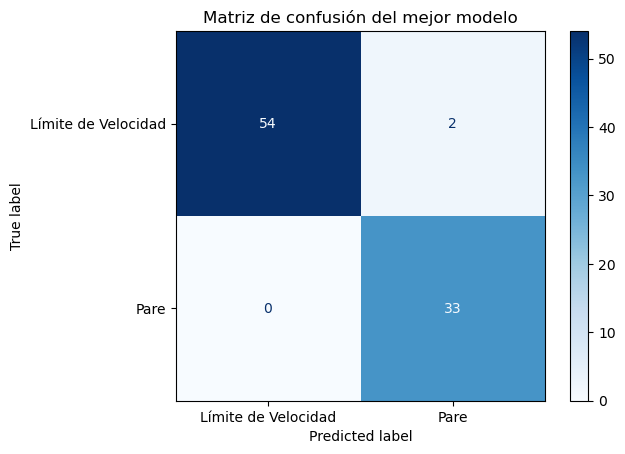

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5253 - loss: 0.8955 - val_accuracy: 0.9318 - val_loss: 0.5815
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5545 - loss: 0.7006 - val_accuracy: 0.8864 - val_loss: 0.6403
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5661 - loss: 0.6780 - val_accuracy: 0.9318 - val_loss: 0.5343
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5789 - loss: 0.6845 - val_accuracy: 0.9318 - val_loss: 0.5099
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5571 - loss: 0.6875 - val_accuracy: 0.9318 - val_loss: 0.5250
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5829 - loss: 0.6701 - val_accuracy: 0.8409 - val_loss: 0.6339
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6045 - loss: 0.6698 - val_accuracy: 0.8409 - val_loss: 0.6314
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6012 - loss: 0.6645 - val_accuracy: 0.8409 - val_loss:

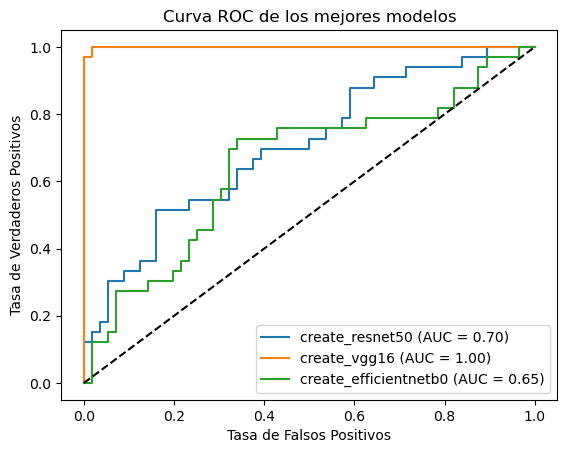

In [13]:
# Tabla con métricas promedio
metrics_df = pd.DataFrame(metrics_summary)
print("\nResumen de métricas promedio de cada modelo:")
print(metrics_df)

# Matriz de confusión del mejor modelo
best_model_idx = np.argmax([m['Precisión promedio'] for m in metrics_summary])
best_model = models[best_model_idx]()
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_valid, y_valid))

y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=["Límite de Velocidad", "Pare"])
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión del mejor modelo")
plt.show()

# Curva ROC
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

if NUM_CLASSES == 2:
    for model_fn, history in roc_data[:3]:
        model = model_fn()
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_valid, y_valid))
        y_scores = model.predict(X_test)[:, 1]
        plot_roc_curve(y_true, y_scores, model_fn.__name__)

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC de los mejores modelos")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend(loc="lower right")
plt.show()